In [1]:
from utils.prepare_data import normalizeAndFillData, normalizeData, encodeCategoricalData
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import numpy as np

# Load data

In [2]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [3]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [4]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [5]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [6]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [7]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [8]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [9]:
from GRANDE import GRANDE


how = "last"

def createModel():
    import os

    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

    params = {
        "depth": 6,  # tree depth
        "n_estimators": 1000,  # number of estimators / trees
        "learning_rate_weights": 0.005,  # learning rate for leaf weights
        "learning_rate_index": 0.01,  # learning rate for split indices
        "learning_rate_values": 0.01,  # learning rate for split values
        "learning_rate_leaf": 0.01,  # learning rate for leafs (logits)
        "optimizer": "adam",  # optimizer
        "cosine_decay_steps": 0,  # decay steps for lr schedule (CosineDecayRestarts)
        "loss": "crossentropy",  # loss function (default 'crossentropy' for binary & multi-class classification and 'mse' for regression)
        "focal_loss": False,  # use focal loss {True, False}
        "temperature": 0.0,  # temperature for stochastic re-weighted GD (0.0, 1.0)
        "from_logits": True,  # use logits for weighting {True, False}
        "use_class_weights": True,  # use class weights for training {True, False}
        "dropout": 0.0,  # dropout rate (here, dropout randomly disables individual estimators of the ensemble during training)
        "selected_variables": 0.8,  # feature subset percentage (0.0, 1.0)
        "data_subset_fraction": 1.0,  # data subset percentage (0.0, 1.0)
    }

    args = {
        "device": "gpu",  # device {'cpu', 'gpu'}
        "epochs": 1_000,  # number of epochs for training
        "early_stopping_epochs": 25,  # patience for early stopping (best weights are restored)
        "batch_size": 64,  # batch size for training
        "cat_idx": [],  # put list of categorical indices
        "objective": "binary",  # objective / task {'binary', 'classification', 'regression'}
        "random_seed": 42,
        "verbose": 0,
    }

    return GRANDE(params=params, args=args)

createModel()

2024-09-27 05:38:51.657031: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 05:38:51.677958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<GRANDE name=grande, built=False>

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: last


## With validate

### Fill missing with zeros (BEST)

In [10]:
from utils.prepare_data import normalizeAndFillData, trainValTestPatients
from utils.class_voter import combineProbas
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)

accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

for trainValPatientsGen, testPatients in trainValTestPatients(patients):
    probas = []
    for trainPatients, valPatients in trainValPatientsGen:
        dfTrain = trainPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
        )
        dfTrain = dfTrain.drop(columns=idColumns)

        dfVal = valPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
        )
        dfVal = dfVal.drop(columns=idColumns)

        dfTest = testPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
        )
        dfTest = dfTest.drop(columns=idColumns)

        dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

        X_train = dfTrain.drop(columns=[labelColumn])
        y_train = dfTrain[labelColumn]

        X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
        y_val = dfVal[labelColumn]  # type: ignore

        X_test = dfTest.drop(columns=[labelColumn])
        y_test = dfTest[labelColumn]

        X_train = X_train.fillna(0)
        X_val = X_val.fillna(0)
        X_test = X_test.fillna(0)

        model = createModel()
        model.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

        # y_pred = model.predict(X_test)
        y_pred_proba = model.predict(X_test)[:, 1]  # For AUC
        probas.append(y_pred_proba)

    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))

    thresholds = np.arange(0.2, 0.81, 0.01)
    differences = []
    for threshold in thresholds:
        y_pred = (finalYProbas > threshold).astype(int)
        recall = recall_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        differences.append(abs(recall - specificity))

    best_threshold = thresholds[np.argmin(differences)]
    finalYPred = (finalYProbas > best_threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, finalYProbas)

    accuracy_score_list.append(accuracy_score(y_test, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(y_test, finalYPred))
    recall_score_list.append(recall_score(y_test, finalYPred))
    auc_score_list.append(roc_auc_score(y_test, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

2024-09-27 05:38:59.976805: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-27 05:38:59.980458: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-27 05:38:59.980542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

I0000 00:00:1727390409.591961 3182943 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_142', 4 bytes spill stores, 4 bytes spill loads



In [11]:
# print(f"AUC: {np.mean(auc_score_list_val)} +- {np.std(auc_score_list_val)}", auc_score_list_val)
# print(f"Accuracy: {np.mean(accuracy_score_list_val)} +- {np.std(accuracy_score_list_val)}", accuracy_score_list_val)
# print(f"Specificity: {np.mean(specificity_score_list_val)} +- {np.std(specificity_score_list_val)}", specificity_score_list_val)
# print(f"Precision: {np.mean(precision_score_list_val)} +- {np.std(precision_score_list_val)}", precision_score_list_val)
# print(f"Recall: {np.mean(recall_score_list_val)} +- {np.std(recall_score_list_val)}", recall_score_list_val)
# print(f"AUC PR: {np.mean(auc_pr_list_val)} +- {np.std(auc_pr_list_val)}", auc_pr_list_val)

print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.8152237111077231 +- 0.023164520530036373 [0.8030075187969925, 0.8086553770444348, 0.8604902667627975, 0.8087238644556598, 0.7952415284787311]
Accuracy: 0.7487671890538733 +- 0.02883489669752217 [0.7355371900826446, 0.7095435684647303, 0.7842323651452282, 0.7800829875518672, 0.7344398340248963]
Specificity: 0.815674214891436 +- 0.04209543694405035 [0.8027210884353742, 0.7551020408163265, 0.8561643835616438, 0.8698630136986302, 0.7945205479452054]
Precision: 0.696985630034209 +- 0.05260562606119664 [0.6741573033707865, 0.625, 0.7529411764705882, 0.7625, 0.6703296703296703]
Recall: 0.6455543113101904 +- 0.014581150846554662 [0.631578947368421, 0.6382978723404256, 0.6736842105263158, 0.6421052631578947, 0.6421052631578947]
AUC PR: 0.7320536734246794 +- 0.04713234069372854 [0.6965541466045294, 0.7006510198965422, 0.8154738014871029, 0.753506696967577, 0.6940827021676459]


### Without fill missing data

In [12]:
from utils.prepare_data import normalizeData, trainValTestPatients
from utils.class_voter import combineProbas


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
specificity_score_list_val = []
sensitivity_score_list_val = []
auc_pr_list_val = []

for trainValPatientsGen, testPatients in trainValTestPatients(patients):
    probas = []
    for trainPatients, valPatients in trainValPatientsGen:
        dfTrain = trainPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
        )
        dfTrain = dfTrain.drop(columns=idColumns)

        dfVal = valPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
        )
        dfVal = dfVal.drop(columns=idColumns)

        dfTest = testPatients.getMeasuresBetween(
            pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
        )
        dfTest = dfTest.drop(columns=idColumns)

        dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

        X_train = dfTrain.drop(columns=[labelColumn])
        y_train = dfTrain[labelColumn]

        X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
        y_val = dfVal[labelColumn] # type: ignore

        X_test = dfTest.drop(columns=[labelColumn])
        y_test = dfTest[labelColumn]

        model = createModel()
        model.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

        # y_pred = model.predict(X_test)
        y_pred_proba = model.predict(X_test)[:, 1]  # For AUC
        probas.append(y_pred_proba)

    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))
    best_threshold = 0.5
    finalYPred = (finalYProbas > best_threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, finalYProbas)

    accuracy_score_list_val.append(accuracy_score(y_test, np.round(y_pred_proba)))
    specificity_score_list_val.append(tn / (tn + fp))
    precision_score_list_val.append(precision_score(y_test, np.round(y_pred_proba)))
    recall_score_list_val.append(recall_score(y_test, np.round(y_pred_proba)))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))
    auc_pr_list_val.append(auc(recall_vals, precision_vals))

In [13]:
print(f"AUC: {np.mean(auc_score_list_val)} +- {np.std(auc_score_list_val)}", auc_score_list_val)
print(f"Accuracy: {np.mean(accuracy_score_list_val)} +- {np.std(accuracy_score_list_val)}", accuracy_score_list_val)
print(f"Specificity: {np.mean(specificity_score_list_val)} +- {np.std(specificity_score_list_val)}", specificity_score_list_val)
print(f"Precision: {np.mean(precision_score_list_val)} +- {np.std(precision_score_list_val)}", precision_score_list_val)
print(f"Recall: {np.mean(recall_score_list_val)} +- {np.std(recall_score_list_val)}", recall_score_list_val)
print(f"AUC PR: {np.mean(auc_pr_list_val)} +- {np.std(auc_pr_list_val)}", auc_pr_list_val)

AUC: 0.8119766084654115 +- 0.026230510227487337 [0.7990691013247404, 0.797872340425532, 0.8628695025234319, 0.8100216294160058, 0.7900504686373467]
Accuracy: 0.7487671890538733 +- 0.02883489669752217 [0.7355371900826446, 0.7095435684647303, 0.7842323651452282, 0.7800829875518672, 0.7344398340248963]
Specificity: 0.7336035784176684 +- 0.015636056673776457 [0.7414965986394558, 0.7278911564625851, 0.7602739726027398, 0.7191780821917808, 0.7191780821917808]
Precision: 0.696985630034209 +- 0.05260562606119664 [0.6741573033707865, 0.625, 0.7529411764705882, 0.7625, 0.6703296703296703]
Recall: 0.6455543113101904 +- 0.014581150846554662 [0.631578947368421, 0.6382978723404256, 0.6736842105263158, 0.6421052631578947, 0.6421052631578947]
AUC PR: 0.7320536734246794 +- 0.04713234069372854 [0.6965541466045294, 0.7006510198965422, 0.8154738014871029, 0.753506696967577, 0.6940827021676459]


### Fill missing with knn

2024-08-08 21:31:12.388302: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1566] failed to allocate 1.00GiB (1073741824 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-08-08 21:31:12.388366: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1566] failed to allocate 921.60MiB (966367744 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


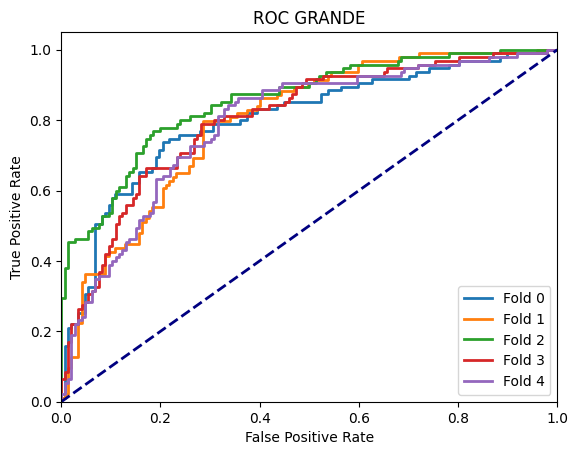

In [14]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from matplotlib import pyplot as plt
import numpy as np


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []

plt.figure()
for i, (trainPatients, valPatients, testPatients) in enumerate(trainValTest()):
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

    # y_pred = model.predict(X_test)
    y_pred_proba = model.predict(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, np.round(y_pred_proba)))
    precision_score_list_val_knn.append(precision_score(y_test, np.round(y_pred_proba)))
    recall_score_list_val_knn.append(recall_score(y_test, np.round(y_pred_proba)))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, lw=2, label=f"Fold {i}")

plt.plot([0, 1], [0, 1], linestyle="--", color="navy", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC GRANDE")
plt.legend(loc="lower right")
plt.show()

In [15]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.8101950007633482
Average Accuracy: 0.7479167381091184
Average Precision: 0.6979014628281124
Average Recall: 0.6349832026875699


In [16]:
from shap import Explainer
import shap

shap.initjs()

In [17]:
from constants import TEMP_PATH

def grandePredict(X):
    proba = model.predict(X)[: ,1]
    return np.round(proba)

expl = Explainer(grandePredict, X_train)
shap_values = expl(X_test)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/GRANDE/GRANDE.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.num_columns] = X[self.num_columns].fillna(self.mean_train_num)
/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/GRANDE/GRANDE.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.num_columns] = X[self.num_columns].fillna(self.mean_t

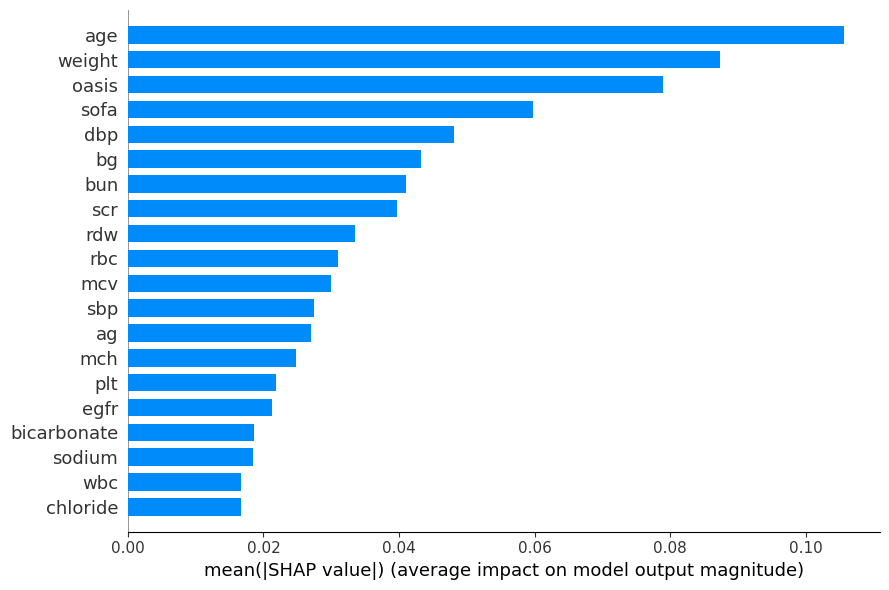

In [24]:
from constants import RESULT_PATH


shap.summary_plot(shap_values, plot_type="bar", show=False, plot_size=[9, 6])
plt.savefig(RESULT_PATH / "shap_grande_summary_plot.svg", format="svg")
plt.show()

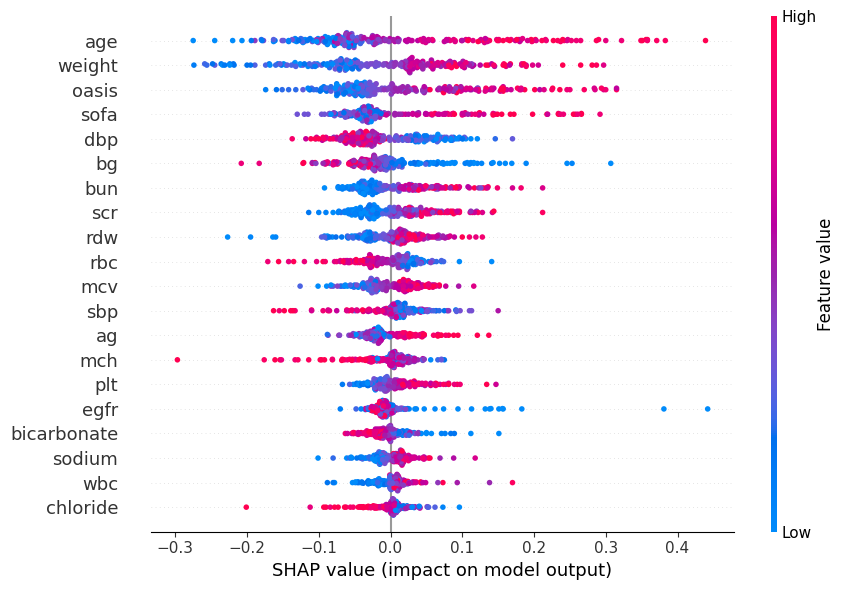

In [25]:
shap.summary_plot(shap_values, show=False, plot_size=[9, 6])
plt.savefig(RESULT_PATH / "shap_grande_beeswarm.svg", format="svg")
plt.show()

### Param tune 

In [ ]:
# from sklearn.base import BaseEstimator, ClassifierMixin
# from sklearn.model_selection import train_test_split


# class GRANDEWrapper(BaseEstimator, ClassifierMixin):
#     def __init__(self, **kwargs):
#         self.params = kwargs
#         self.args = {
#             "device": "gpu",  # device {'cpu', 'gpu'}
#             "epochs": 1_000,  # number of epochs for training
#             "early_stopping_epochs": 25,  # patience for early stopping (best weights are restored)
#             "batch_size": 64,  # batch size for training
#             "cat_idx": [],  # put list of categorical indices
#             "objective": "binary",  # objective / task {'binary', 'classification', 'regression'}
#             "random_seed": 42,
#             "verbose": 0,
#         }
#         self.model = None

#     def set_params(self, **params):
#         for key, value in params.items():
#             self.params[key] = value
#         return self

#     def get_params(self, deep=True):
#         return self.params

#     def fit(self, X, y):
#         self.classes_ = np.unique(y)

#         X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=self.args["random_seed"])

#         self.model = GRANDE(params=self.params, args=self.args)
#         self.model.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
#         return self

#     def predict(self, X):
#         if self.model is None:
#             raise Exception("Model has not been trained yet!")
#         return self.model.predict(X)

#     def predict_proba(self, X):
#         if self.model is None:
#             raise Exception("Model has not been trained yet!")
#         return self.model.predict(X)

#     def score(self, X, y):
#         y_pred_proba = self.predict_proba(X)[:, 1]  # For binary classification
#         return roc_auc_score(y, y_pred_proba)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from utils.prepare_data import normalizeData


# paramGrid = {
#     "params__device"
#     "params__depth": [4, 6, 8],
#     "params__n_estimators": [500, 1000, 1500],
#     "params__learning_rate_weights": [0.001, 0.005, 0.01],
#     "params__learning_rate_index": [0.005, 0.01, 0.05],
#     "params__learning_rate_values": [0.005, 0.01, 0.05],
#     "params__learning_rate_leaf": [0.005, 0.01, 0.05],
#     "params__optimizer": ["adam", "sgd"],
#     "params__cosine_decay_steps": [0, 100, 500],
#     "params__loss": ["crossentropy", "mse"],
#     "params__focal_loss": [True, False],
#     "params__temperature": [0.0, 0.1, 0.5],
#     "params__from_logits": [True, False],
#     "params__use_class_weights": [True, False],
#     "params__dropout": [0.0, 0.1, 0.5],
#     "params__selected_variables": [0.6, 0.8, 1.0],
#     "params__data_subset_fraction": [0.8, 1.0],
# }


# gridModel = GRANDEWrapper()
# gridSearch = GridSearchCV(
#     estimator=gridModel,
#     param_grid=paramGrid,
#     scoring="roc_auc",
#     cv=5,
#     verbose=2,
#     n_jobs=3,
# )

# dfAll = patients.getMeasuresBetween(
#     pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
# )
# dfAll = dfAll.drop(columns=idColumns)
# dfAll, _, _ = normalizeData(dfAll, dfAll)
# X_all = dfAll.drop(columns=[labelColumn])
# y_all = dfAll[labelColumn]

# gridSearch.fit(X_all, y_all)

# print("Params", gridSearch.best_params_)
# print("Scores", gridSearch.best_score_)